# Machine learning to optain the physical parameters from the photometry of the stars

Inputs: (u_cfis,g_PS,r_PS,i_PS,z_PS,y_PS)
Ouputs: (Types, [Fe/H])


*Feb 2018 by Guillaume THOMAS guillaume.thomas@nrc-cnrc.gc.ca*

*Copyright (c) 2018 NRC Herzberg Astronomy & Astrophysics All rights reserved. *


In [10]:
import numpy as np
from astropy.io import fits
from astropy import units
from astropy.coordinates import SkyCoord
from astropy import units
import matplotlib.pyplot as plt
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation, multiply
from keras.optimizers import Adam
from keras import backend as K
import pylab as P
from scipy.optimize import curve_fit
from matplotlib import gridspec

logg_thres=3.5 # Value of log(g) to separate the giants from the dwarfs

## 1) Load the segue catalogue

### 1.1 To do the Monte-Carlo realization of the input

In [11]:
##############################
## Do the montecarlo sample ##
##############################
def monte_carlo(ra,dec,u,g,r,i,z,y,G,BP,RP,du,dg,dr,di,dz,dy,Teff,logg,feh,dTeff,dlogg,dfeh):
    nb_increase=10 # Number of montecarlo sample 
    
    ra_out=np.zeros(len(ra)*nb_increase)
    dec_out=np.zeros(len(ra)*nb_increase)
    u_out=np.zeros(len(ra)*nb_increase)
    g_out=np.zeros(len(ra)*nb_increase)
    r_out=np.zeros(len(ra)*nb_increase)
    i_out=np.zeros(len(ra)*nb_increase)
    z_out=np.zeros(len(ra)*nb_increase)
    y_out=np.zeros(len(ra)*nb_increase)
    G_out=np.zeros(len(ra)*nb_increase)
    BP_out=np.zeros(len(ra)*nb_increase)
    RP_out=np.zeros(len(ra)*nb_increase)
    du_out=np.zeros(len(ra)*nb_increase)
    dg_out=np.zeros(len(ra)*nb_increase)
    dr_out=np.zeros(len(ra)*nb_increase)
    di_out=np.zeros(len(ra)*nb_increase)
    dz_out=np.zeros(len(ra)*nb_increase)
    dy_out=np.zeros(len(ra)*nb_increase)
    Teff_out=np.zeros(len(ra)*nb_increase)
    logg_out=np.zeros(len(ra)*nb_increase)
    feh_out=np.zeros(len(ra)*nb_increase)
    dTeff_out=np.zeros(len(ra)*nb_increase)
    dlogg_out=np.zeros(len(ra)*nb_increase)
    dfeh_out=np.zeros(len(ra)*nb_increase)

    # The 1st raw
    ra_out[0:len(ra)]=ra
    dec_out[0:len(ra)]=dec
    u_out[0:len(ra)]=u
    g_out[0:len(ra)]=g
    r_out[0:len(ra)]=r
    i_out[0:len(ra)]=i
    z_out[0:len(ra)]=z
    y_out[0:len(ra)]=y
    G_out[0:len(ra)]=G
    BP_out[0:len(ra)]=BP
    RP_out[0:len(ra)]=RP
    du_out[0:len(ra)]=du
    dg_out[0:len(ra)]=dg
    dr_out[0:len(ra)]=dr
    di_out[0:len(ra)]=di
    dz_out[0:len(ra)]=dz
    dy_out[0:len(ra)]=dy
    Teff_out[0:len(ra)]=Teff
    logg_out[0:len(ra)]=logg
    feh_out[0:len(ra)]=feh
    dTeff_out[0:len(ra)]=dTeff
    dlogg_out[0:len(ra)]=dlogg
    dfeh_out[0:len(ra)]=dfeh
    
    for nb in range(1,nb_increase):
        ra_out[nb*len(ra):(nb+1)*len(ra)]=ra
        dec_out[nb*len(ra):(nb+1)*len(ra)]=dec
        u_out[nb*len(ra):(nb+1)*len(ra)]=u+np.random.normal(0.0, 1.0, len(ra))*du
        g_out[nb*len(ra):(nb+1)*len(ra)]=g+np.random.normal(0.0, 1.0, len(ra))*dg
        r_out[nb*len(ra):(nb+1)*len(ra)]=r+np.random.normal(0.0, 1.0, len(ra))*dr
        i_out[nb*len(ra):(nb+1)*len(ra)]=i+np.random.normal(0.0, 1.0, len(ra))*di
        z_out[nb*len(ra):(nb+1)*len(ra)]=z+np.random.normal(0.0, 1.0, len(ra))*dz
        y_out[nb*len(ra):(nb+1)*len(ra)]=y+np.random.normal(0.0, 1.0, len(ra))*dy
        G_out[nb*len(ra):(nb+1)*len(ra)]=G+np.random.normal(0.0, 1.0, len(ra))*0.0
        BP_out[nb*len(ra):(nb+1)*len(ra)]=BP+np.random.normal(0.0, 1.0, len(ra))*0.0
        RP_out[nb*len(ra):(nb+1)*len(ra)]=RP+np.random.normal(0.0, 1.0, len(ra))*0.0
        du_out[nb*len(ra):(nb+1)*len(ra)]=du
        dg_out[nb*len(ra):(nb+1)*len(ra)]=dg
        dr_out[nb*len(ra):(nb+1)*len(ra)]=dr
        di_out[nb*len(ra):(nb+1)*len(ra)]=di
        dz_out[nb*len(ra):(nb+1)*len(ra)]=dz
        dy_out[nb*len(ra):(nb+1)*len(ra)]=dy
        Teff_out[nb*len(ra):(nb+1)*len(ra)]=Teff+np.random.normal(0.0, 1.0, len(ra))*dTeff
        logg_out[nb*len(ra):(nb+1)*len(ra)]=logg+np.random.normal(0.0, 1.0, len(ra))*dlogg
        feh_out[nb*len(ra):(nb+1)*len(ra)]=feh+np.random.normal(0.0, 1.0, len(ra))*dfeh
        dTeff_out[nb*len(ra):(nb+1)*len(ra)]=dTeff
        dlogg_out[nb*len(ra):(nb+1)*len(ra)]=dlogg
        dfeh_out[nb*len(ra):(nb+1)*len(ra)]=dfeh  
    
    return ra_out,dec_out,u_out,g_out,r_out,i_out,z_out,y_out,G_out,BP_out,RP_out,du_out,dg_out,dr_out,di_out,dz_out,dy_out,Teff_out,logg_out,feh_out,dTeff_out,dlogg_out,dfeh_out

### 1.2 Remove the extinction

In [12]:
###############
### Get EBV ###
###############
def get_EBV(ra,dec):
	# Transformation of coordinate
	c_icrs = SkyCoord(ra=ra*units.degree, dec=dec*units.degree, frame='icrs')
	l=c_icrs.galactic.l.degree
	b=c_icrs.galactic.b.degree
	# Read the map of schlegel et al., 98
	EBV=np.zeros(len(ra))
	ebvlist = fits.open('./polecount_dust.fits')
	EBV_map= ebvlist[0].data
	ebvlist.close()
	pix_size=0.1 # Degree
	for i in range(0,len(ra)):
		pb=int((b[i]+90.0)/pix_size)
		pl=int(l[i]/pix_size)
		EBV[i]=EBV_map[pb,pl]
		#print l[i],b[i],pl,pb,EBV_map[pb,pl]
	return EBV

### 1.3 Load the data and do the realization of the Monte-Carlo sample and remove the extinction

In [13]:

#########################
###   Load the data   ###
#########################
def load_data():
    hdulist = fits.open('cfis_ps_segue_gaia.fits')
    data=hdulist[1].data

    ra=data.field(0)
    dec=data.field(1)
    u=data.field(2) #u
    g=data.field(10) #g
    r=data.field(12) #r
    i=data.field(14) #i
    z=data.field(16) #z
    y=data.field(18) #y
    G=data.field(91) #G
    BP=data.field(93) #BP
    RP=data.field(95) #RP
    du=data.field(3) #du
    dg=data.field(11) #dg
    dr=data.field(13) #dr
    di=data.field(15) #di
    dz=data.field(17) #dz
    dy=data.field(19) #dy
    nG=data.field(90) #nobs G
    nBP=data.field(92) #nobs BP
    nRP=data.field(94) #nobs RP


    Teff=data.field(58) #Teff
    logg=data.field(60) #log(g)
    feh=data.field(62)  #[Fe/H]
    dTeff=data.field(59) #Teff
    dlogg=data.field(61) #log(g)
    dfeh=data.field(63)  #[Fe/H]
    SNR=data.field(66) #SNR
    hdulist.close()
    
    
    # Cut in uncertainties and select only stars having gaia photometry and apply it to each column
    dTeff_thres=10000.0#120.0
    dlogg_thres=10000.0#0.13
    dfeh_thres=10000.0#0.2
    SNR_thres=50.0 
    FeH_thres=-40.0
    sel=np.zeros(len(ra)) # array where stars with 0 will not be selected for this study
    sel[((dTeff<=dTeff_thres)*(dlogg<=dlogg_thres)*(dfeh<=dfeh_thres)*(SNR>=SNR_thres)*(feh>=FeH_thres)*(nG>0)*(nBP>0)*(nRP>0))]=1
 
    ra=ra[(sel>0.0)]
    dec=dec[(sel>0.0)]
    u=u[(sel>0.0)] 
    g=g[(sel>0.0)] 
    r=r[(sel>0.0)] 
    i=i[(sel>0.0)] 
    z=z[(sel>0.0)] 
    y=y[(sel>0.0)]
    G=G[(sel>0.0)] 
    BP=BP[(sel>0.0)] 
    RP=RP[(sel>0.0)] 
    du=du[(sel>0.0)] 
    dg=dg[(sel>0.0)] 
    dr=dr[(sel>0.0)] 
    di=di[(sel>0.0)] 
    dz=dz[(sel>0.0)] 
    dy=dy[(sel>0.0)] 
    Teff=Teff[(sel>0.0)] 
    logg=logg[(sel>0.0)] 
    feh=feh[(sel>0.0)] 
    dTeff=dTeff[(sel>0.0)] 
    dlogg=dlogg[(sel>0.0)] 
    dfeh=dfeh[(sel>0.0)]
    SNR=SNR[(sel>0.0)] 
    
    
    
    # Do a monte-carlo sample
    ra,dec,u,g,r,i,z,y,G,BP,RP,du,dg,dr,di,dz,dy,Teff,logg,feh,dTeff,dlogg,dfeh=monte_carlo(ra,dec,u,g,r,i,z,y,G,BP,RP,du,dg,dr,di,dz,dy,Teff,logg,feh,dTeff,dlogg,dfeh)


    # Calcul the extinction
    EBV=get_EBV(ra,dec)
    
    # Dered data
    u-=4.239*EBV # I'm pretending these are SDSS band for u, but it is not and PS for the others!
    g-=3.172*EBV #
    r-=2.271*EBV #
    i-=1.682*EBV #
    z-=1.322*EBV #
    y-=1.087*EBV #
    G-=0.85926*EBV # Assume extinction coefficiants from Malhan+ 2018b
    BP-=1.06794*EBV
    RP-=0.65199*EBV
    
   

    # Generate the inputs and outputs catalogues
    inputs=np.zeros((len(ra),8))
    inputs[:,0]=(u)
    inputs[:,1]=(g)
    inputs[:,2]=(r)
    inputs[:,3]=i
    inputs[:,4]=z
    inputs[:,5]=G
    inputs[:,6]=BP
    inputs[:,7]=RP


    
    outputs=np.zeros((len(ra),3))
    outputs[:,0]=Teff # Teff
    outputs[:,1]=logg # log(g)
    outputs[:,2]=(feh)

   
    error=np.zeros((len(ra),3))
    error[:,0]=dTeff
    error[:,1]=dlogg
    error[:,2]=dfeh

    return inputs,outputs,error

# 2) Custom loss
a weighted mean-absolute-error.
\begin{equation}
loss = \frac{1}{m}\sum{|y_{true}-y_{pred}|}
\end{equation}

In [14]:
from keras.engine.topology import Layer

class Predictor_weighted_loss_layer(Layer):
    __name__ = u'pred_loss_layer'

    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(Predictor_weighted_loss_layer, self).__init__(**kwargs)

    def lossfun(self, y_true, y_pred, y_err):
        #mae_loss = K.mean(K.abs((y_true - y_pred))/(y_err+0.01))
        mae_loss = K.mean(K.abs((y_true - y_pred)))
        return mae_loss

    def call(self, inputs):
        y_true = inputs[0]
        y_pred = inputs[1]
        y_err = inputs[2]
        loss = self.lossfun(y_true, y_pred, y_err)
        self.add_loss(loss, inputs=inputs)

        return y_true
    
# this is used to compile the model, returning a zero-loss so no gradients are returned by the regular keras way of
# analyzing a loss function. The weighted loss above will be the only one that matters
def zero_loss(y_true, y_pred):
    return K.zeros_like(y_true)

# 3) Load the data

and apply a first color cut to remove the A-types stars and others contaminents

142750
132011


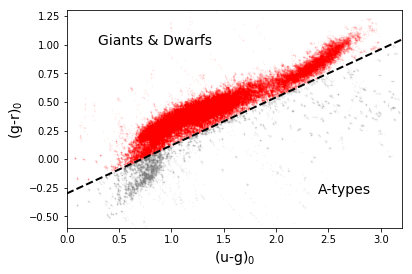

In [15]:
# Load the training and the test 
inputs,outputs,error=load_data()

print len(inputs)

a_star=inputs[(0.42*(inputs[:,0]-inputs[:,1])-0.3>(inputs[:,1]-inputs[:,2]))]
# Apply a color cut to remove the contaminent stars (i.e. that are not giants or dwarfs)
outputs=outputs[(0.42*(inputs[:,0]-inputs[:,1])-0.3<=(inputs[:,1]-inputs[:,2]))] # 0.42*(u-g)-0.3 <= (g-r) 
error=error[(0.42*(inputs[:,0]-inputs[:,1])-0.3<=(inputs[:,1]-inputs[:,2]))] # 0.42*(u-g)-0.3 <= (g-r) 
inputs=inputs[(0.42*(inputs[:,0]-inputs[:,1])-0.3<=(inputs[:,1]-inputs[:,2]))] # 0.42*(u-g)-0.3 <= (g-r) 

print len(inputs)

plt.scatter(inputs[:,0]-inputs[:,1],inputs[:,1]-inputs[:,2],s=0.5,c="red",alpha=0.05,edgecolors=None, cmap=plt.cm.RdBu,rasterized=True)
plt.scatter(a_star[:,0]-a_star[:,1],a_star[:,1]-a_star[:,2],s=0.5,c='grey',alpha=0.05,edgecolors=None, cmap=plt.cm.RdBu,rasterized=True)
line=np.arange(0.0,3.5,0.002)
plt.plot(line,0.42*line-0.3,"k--",lw=2)
plt.xlabel('(u-g)$_0$',fontsize=14)
plt.ylabel('(g-r)$_0$',fontsize=14)
plt.xlim(0.0,3.2)
plt.ylim(-0.6,1.3)
plt.ylabel('(g-r)$_0$')
plt.annotate(r"Giants & Dwarfs", xy=(0.3,1.0), xytext=(0.3, 1.0), color='black',size=14)
plt.annotate(r"A-types", xy=(2.4,-0.3), xytext=(2.4, -0.3), color='black',size=14)

#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.rcParams['pdf.fonttype']=42
plt.savefig("color_color_ML.pdf", format='pdf')
plt.show()

# 4) 1nd ML: Determine log(g)

(u)grizy -> log(g) for stars with 1.3<=(u-i)<=2.6 and 0.05>=(g-z)

### 4.1 Define the layers

In [16]:
def ML2_get_logg(inputs,outputs):
    
    input_shape = inputs.shape[1]
    output_shape = 1
    initializer='he_normal'
    
    inputs = Input(shape=(input_shape,))
    
    x = Dense(32,kernel_initializer=initializer)(inputs)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)
    
    x = Dense(5096,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)    
    
    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)    

    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)  
    
    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)  

    
    pred = Dense(output_shape,activation='linear')(x)
    
    return Model(inputs, pred)


def set_lr(model,learning_rate):
    K.set_value(model.optimizer.lr,learning_rate)
    return model


### 4.2 Select the stars in the good range of color 

In [17]:
# Apply the color cuts
input_forML2 =inputs[((inputs[:,0]-inputs[:,3]>=1.3)*(inputs[:,0]-inputs[:,3]<=2.6)*(inputs[:,2]-inputs[:,4]>=0.05))]
output_forML2=outputs[((inputs[:,0]-inputs[:,3]>=1.3)*(inputs[:,0]-inputs[:,3]<=2.6)*(inputs[:,2]-inputs[:,4]>=0.05))]
error_forML2=error[((inputs[:,0]-inputs[:,3]>=1.3)*(inputs[:,0]-inputs[:,3]<=2.6)*(inputs[:,2]-inputs[:,4]>=0.05))]

### 4.3 Select the stars in that region which have a good mesurment on their log(g)
and generation of the training and testing sets

(77901, 8)
0.0720173423019


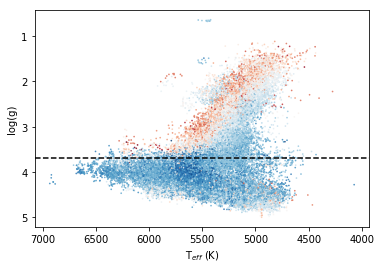

In [18]:
print input_forML2.shape
# Select stars with low uncertainties in logg
input_forML2 = input_forML2[(error_forML2[:,1]<=0.16)]
output_forML2 = output_forML2[(error_forML2[:,1]<=0.16)]
error_forML2 = error_forML2[(error_forML2[:,1]<=0.16)]
print np.mean(error_forML2[:,1])

# Plot the position of the stars in a Teff-logg diagram
plt.scatter(output_forML2[:,0],output_forML2[:,1],s=0.5,c=output_forML2[:,2],alpha=0.8,edgecolors=None, cmap=plt.cm.RdBu)
plt.axhline(y=3.7, color='k', linestyle='--')
plt.xlabel('T$_{eff}$ (K)')
plt.ylabel('log(g)')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

Teff_forML2= output_forML2[:,0]
feh_forML2= output_forML2[:,2]
output_forML2= output_forML2[:,1]
error_forML2=    error_forML2[:,1]


###########
#### Need to keep all these transformation => you should make the transformation subroutine
###########
color_mean_logg=np.zeros(len(input_forML2[0,:]))
color_std_logg=np.zeros(len(input_forML2[0,:]))
for i in range(0,len(input_forML2[0,:])):
    color_mean_logg[i]=np.mean(input_forML2[:,i])
    color_std_logg[i]=np.std(input_forML2[:,i])
mean_logg=np.mean(output_forML2)
std_logg=np.std(output_forML2)
error_logg_min=np.min(error_forML2)
error_logg_min=np.max(error_forML2)

m=input_forML2.shape[0]
permutation=list(np.random.permutation(m))
# Generate train and test sets
for i in range(0,len(input_forML2[0,:])):
    input_forML2[:,i]=(input_forML2[permutation,i]-color_mean_logg[i])/color_std_logg[i]
output_forML2=(output_forML2[permutation]-np.mean(output_forML2))/np.std(output_forML2)
error_forML2=(error_forML2[permutation]-np.min(error_forML2))/(np.max(error_forML2)-np.min(error_forML2))

input_forML2_train=input_forML2[0:int(80.0/100*m),:]; input_forML2_test=input_forML2[int(80.0/100*m):m,:]
output_forML2_train=output_forML2[0:int(80.0/100*m)]; output_forML2_test=output_forML2[int(80.0/100*m):m]
error_forML2_train=error_forML2[0:int(80.0/100*m)]; error_forML2_test=error_forML2[int(80.0/100*m):m]
Teff_forML2_train=Teff_forML2[0:int(80.0/100*m)]; Teff_forML2_test=Teff_forML2[int(80.0/100*m):m]
feh_forML2_train=feh_forML2[0:int(80.0/100*m)]; feh_forML2_test=feh_forML2[int(80.0/100*m):m]


# Save the color and logg transformation
out_ML2=np.zeros((1,len(input_forML2[0,:])*2+2))
out_ML2[0,0:len(input_forML2[0,:])]=color_mean_logg
out_ML2[0,len(input_forML2[0,:]):2*len(input_forML2[0,:])]=color_std_logg
out_ML2[0,2*len(input_forML2[0,:])]=mean_logg
out_ML2[0,2*len(input_forML2[0,:])+1]=std_logg
np.savetxt("color_proba_giant.asc",out_ML2,delimiter=" ")



### 4.4 Do the machine learning

In [19]:
# Apply the ML
batch_size = 5096 # Mini batch size
lr=0.001 # Learning rate
optimizer = Adam(lr=lr) # Adam optimization 
epochs = 5


## Build and compile the model
regressor2 = ML2_get_logg(input_forML2_train,output_forML2_train)

x = Input(shape=(input_forML2_train.shape[1],))
logg_true = Input(shape=(1,))
logg_err = Input(shape=(1,))
logg_pred = regressor2(x)



pred_loss_ML2 = Predictor_weighted_loss_layer()([logg_true, logg_pred, logg_err])
pred_trainer2 = Model(inputs=[x,logg_true,logg_err],
                     outputs=[pred_loss_ML2])

pred_trainer2.compile(optimizer=optimizer, loss=zero_loss)


pred_trainer2 = set_lr(pred_trainer2,lr)
history21 = pred_trainer2.fit([input_forML2_train,output_forML2_train,error_forML2_train],output_forML2_train,
                         epochs=epochs, verbose=1,
                         validation_data=([input_forML2_test,output_forML2_test,error_forML2_test],output_forML2_test))


# With a second lr 
lr=0.0001 # Learning rate
epochs = 5
pred_trainer2 = set_lr(pred_trainer2,lr)
history22 = pred_trainer2.fit([input_forML2_train,output_forML2_train,error_forML2_train],output_forML2_train,
                         epochs=epochs, verbose=1,
                         validation_data=([input_forML2_test,output_forML2_test,error_forML2_test],output_forML2_test))

# With a third lr 
lr=0.00001 # Learning rate
epochs = 5
pred_trainer2 = set_lr(pred_trainer2,lr)
history23 = pred_trainer2.fit([input_forML2_train,output_forML2_train,error_forML2_train],output_forML2_train,
                         epochs=epochs, verbose=1,
                         validation_data=([input_forML2_test,output_forML2_test,error_forML2_test],output_forML2_test))


pred_trainer2.save('giant_dwarf_class.h5')

# Get the prediction of the ML
preds_train = regressor2.predict(input_forML2_train)
preds_test  = regressor2.predict(input_forML2_test)

Train on 60663 samples, validate on 15166 samples
Epoch 1/5
60663/60663 [==============================] - 358s 6ms/step - loss: 0.5580 - val_loss: 0.4695
Epoch 2/5
60663/60663 [==============================] - 325s 5ms/step - loss: 0.5063 - val_loss: 0.5272
Epoch 3/5
60663/60663 [==============================] - 330s 5ms/step - loss: 0.5003 - val_loss: 0.4651
Epoch 4/5
60663/60663 [==============================] - 234s 4ms/step - loss: 0.4925 - val_loss: 0.4571
Epoch 5/5
60663/60663 [==============================] - 166s 3ms/step - loss: 0.4905 - val_loss: 0.4815
Train on 60663 samples, validate on 15166 samples
Epoch 1/5
60663/60663 [==============================] - 150s 2ms/step - loss: 0.4641 - val_loss: 0.4618
Epoch 2/5
60663/60663 [==============================] - 178s 3ms/step - loss: 0.4589 - val_loss: 0.4352
Epoch 3/5
60663/60663 [==============================] - 181s 3ms/step - loss: 0.4581 - val_loss: 0.4310
Epoch 4/5
60663/60663 [==============================] - 186

### 4.5 Re-transforme in physical units the output of the machine learning

In [305]:
preds_train_phys = preds_train[:,0] * std_logg + mean_logg
preds_test_phys  = preds_test[:,0]  * std_logg + mean_logg

output_forML2_train_phys=output_forML2_train * std_logg + mean_logg
output_forML2_test_phys =output_forML2_test  * std_logg + mean_logg

print preds_train_phys.min(),output_forML2_train_phys.min()
print preds_train_phys.max(),output_forML2_train_phys.max()

input_forML2_train_phys=input_forML2_train * color_std_logg + color_mean_logg



1.19128 0.59613993208
5.35789 4.95182718848


### 4.6 Check the precision of the NN

In [306]:
# Define the exp function
def proba(x, a, b, c):
    return a / (1.0+np.exp((x-b)/c) )


### Train sample ###
Composition of the initial sample : Giants 19.82%   Dwarf 80.18% 
Photometric Giants : Completness 65.67%   Purity 79.06% 
Photometric Dwarfs : Completness 95.70%   Purity 91.86% 

### Test sample ###
Composition of the initial sample : Giants 19.94%   Dwarf 80.06% 
Photometric Giants : Completness 66.49%   Purity 79.42% 
Photometric Dwarfs : Completness 95.71%   Purity 91.98% 


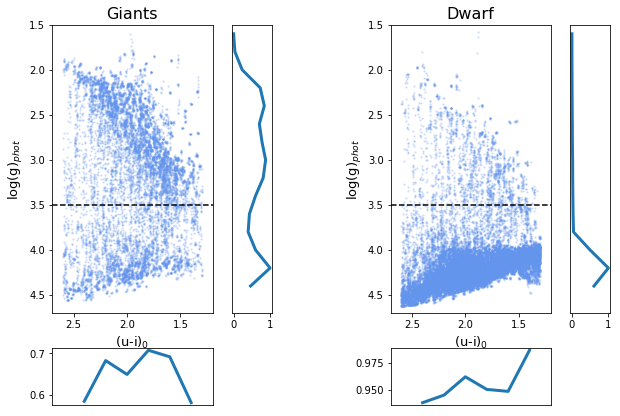

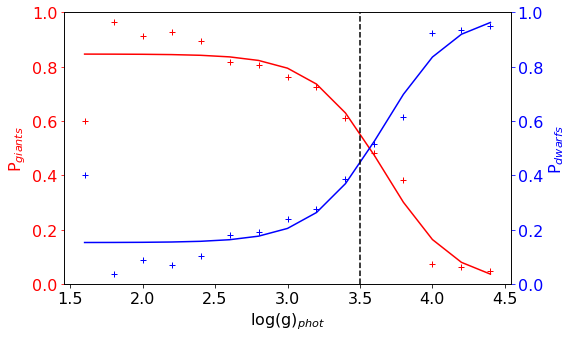

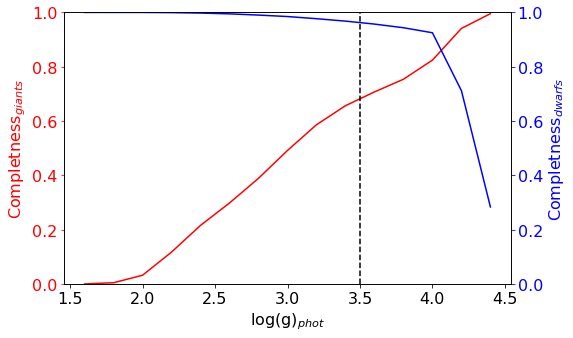

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [310]:
# Calcul mean value
bin_logg_train=np.linspace(preds_train_phys.min(),preds_train_phys.max(),20)
bin_logg=np.zeros(len(bin_logg_train)-1)
mean_logg_train=np.zeros(len(bin_logg_train)-1)
std_logg_train=np.zeros(len(bin_logg_train)-1)
mean_logg_test=np.zeros(len(bin_logg_train)-1)
std_logg_test=np.zeros(len(bin_logg_train)-1)
for i in range(0,len(bin_logg)):
    bin_logg[i]=0.5*(bin_logg_train[i]+bin_logg_train[i+1])
    train=output_forML2_train_phys[((preds_train_phys>=bin_logg_train[i])*(preds_train_phys<bin_logg_train[i+1]))]
    test=output_forML2_test_phys[((preds_test_phys>=bin_logg_train[i])*(preds_test_phys<bin_logg_train[i+1]))]
    preds_train_bin=preds_train_phys[((preds_train_phys>=bin_logg_train[i])*(preds_train_phys<bin_logg_train[i+1]))]
    preds_test_bin=preds_test_phys[((preds_test_phys>=bin_logg_train[i])*(preds_test_phys<bin_logg_train[i+1]))]

    mean_logg_train[i]=np.mean((train-preds_train_bin))
    std_logg_train[i]=np.std((train-preds_train_bin))
    mean_logg_test[i]=np.mean((test-preds_test_bin))
    std_logg_test[i]=np.std((test-preds_test_bin))    
 

plt.show()
plt.close()



correct_giants_train=len(preds_train_phys[((preds_train_phys<=logg_thres)*(output_forML2_train_phys<=logg_thres))])
uncorrect_giants_train=len(preds_train_phys[((preds_train_phys<=logg_thres)*(output_forML2_train_phys>logg_thres))])
correct_giants_test=len(preds_test_phys[((preds_test_phys<=logg_thres)*(output_forML2_test_phys<=logg_thres))])
uncorrect_giants_test=len(preds_test_phys[((preds_test_phys<=logg_thres)*(output_forML2_test_phys>logg_thres))])

correct_dwarf_train=len(preds_train_phys[((preds_train_phys>logg_thres)*(output_forML2_train_phys>logg_thres))])
uncorrect_dwarf_train=len(preds_train_phys[((preds_train_phys>logg_thres)*(output_forML2_train_phys<=logg_thres))])
correct_dwarf_test=len(preds_test_phys[((preds_test_phys>logg_thres)*(output_forML2_test_phys>logg_thres))])
uncorrect_dwarf_test=len(preds_test_phys[((preds_test_phys>logg_thres)*(output_forML2_test_phys<=logg_thres))])


print "\n### Train sample ###"
print "Composition of the initial sample : Giants %.2f%%   Dwarf %.2f%% " %((correct_giants_train+uncorrect_dwarf_train)/float(uncorrect_giants_train+correct_dwarf_train+correct_giants_train+uncorrect_dwarf_train)*100.0,(uncorrect_giants_train+correct_dwarf_train)/float(uncorrect_giants_train+correct_dwarf_train+correct_giants_train+uncorrect_dwarf_train)*100.0)
print "Photometric Giants : Completness %.2f%%   Purity %.2f%% " %((correct_giants_train)/float(uncorrect_dwarf_train+correct_giants_train)*100.0,(correct_giants_train)/float(uncorrect_giants_train+correct_giants_train)*100.0)
print "Photometric Dwarfs : Completness %.2f%%   Purity %.2f%% " %((correct_dwarf_train)/float(uncorrect_giants_train+correct_dwarf_train)*100.0,(correct_dwarf_train)/float(uncorrect_dwarf_train+correct_dwarf_train)*100.0)


print "\n### Test sample ###"
print "Composition of the initial sample : Giants %.2f%%   Dwarf %.2f%% " %((correct_giants_test+uncorrect_dwarf_test)/float(uncorrect_giants_test+correct_dwarf_test+correct_giants_test+uncorrect_dwarf_test)*100.0,(uncorrect_giants_test+correct_dwarf_test)/float(uncorrect_giants_test+correct_dwarf_test+correct_giants_test+uncorrect_dwarf_test)*100.0)
print "Photometric Giants : Completness %.2f%%   Purity %.2f%% " %((correct_giants_test)/float(uncorrect_dwarf_test+correct_giants_test)*100.0,(correct_giants_test)/float(uncorrect_giants_test+correct_giants_test)*100.0)
print "Photometric Dwarfs : Completness %.2f%%   Purity %.2f%% " %((correct_dwarf_test)/float(uncorrect_giants_test+correct_dwarf_test)*100.0,(correct_dwarf_test)/float(uncorrect_dwarf_test+correct_dwarf_test)*100.0)



class_train=np.zeros(len(preds_train_phys))
class_test=np.zeros(len(preds_test_phys))
class_train[(output_forML2_train_phys<=logg_thres)]=1 # Giants
class_train[(output_forML2_train_phys>logg_thres)] =0 # Dwarfs
class_test[(output_forML2_test_phys<=logg_thres)]=1 # Giants
class_test[(output_forML2_test_phys>logg_thres)] =0 # Dwarfs




# Calcul the distribution for giants
bins=np.arange(1.3,2.6,0.2)
binsl1=np.copy(np.zeros(len(bins)-1))
nl1, bins, patches= P.hist(input_forML2_train_phys[(class_train==1),0]-input_forML2_train_phys[(class_train==1),3],bins,histtype='stepfilled',lw=1)
nl1_tmp, bins_tmp, patches_tmp= P.hist(input_forML2_train_phys[((class_train==1)*(preds_train_phys<=logg_thres)),0]-input_forML2_train_phys[((class_train==1)*(preds_train_phys<=logg_thres)),3],bins,histtype='stepfilled',lw=1)
nl1=nl1_tmp/nl1
for i in range(0,len(binsl1)):
    binsl1[i]=0.5*(bins[i]+bins[i+1])
plt.close()

bins=np.arange(1.5,4.7,0.2)
binsb1=np.copy(np.zeros(len(bins)-1))
nb1, bins, patches= P.hist(preds_train_phys[(class_train==1)],bins,histtype='stepfilled',lw=1)

for i in range(0,len(binsb1)):
    binsb1[i]=0.5*(bins[i]+bins[i+1])
plt.close()


# Calcul the distribution for dwarfs
bins=np.arange(1.3,2.6,0.2)
binsl2=np.copy(np.zeros(len(bins)-1))
nl2, bins, patches= P.hist(input_forML2_train_phys[(class_train==0),0]-input_forML2_train_phys[(class_train==0),3],bins,histtype='stepfilled',lw=1)
nl2_tmp, bins_tmp, patches_tmp= P.hist(input_forML2_train_phys[((class_train==0)*(preds_train_phys>logg_thres)),0]-input_forML2_train_phys[((class_train==0)*(preds_train_phys>logg_thres)),3],bins,histtype='stepfilled',lw=1)
nl2=nl2_tmp/nl2
for i in range(0,len(binsl2)):
    binsl2[i]=0.5*(bins[i]+bins[i+1])
plt.close()

bins=np.arange(1.5,4.7,0.2)
binsb2=np.copy(np.zeros(len(bins)-1))
nb2, bins, patches= P.hist(preds_train_phys[(class_train==0)],bins,histtype='stepfilled',lw=1)
for i in range(0,len(binsb2)):
    binsb2[i]=0.5*(bins[i]+bins[i+1])
plt.close()

# Calcul the probability of a star to be a giant or to be a dwarf
proba_g=nb1/(nb1+nb2*1.0)
logg_phot=binsb2[(np.isfinite(proba_g))]
proba_g=proba_g[(np.isfinite(proba_g))]
(a_proba,b_proba,c_proba), pcov = curve_fit(proba, logg_phot, proba_g)
proba_g_fit=proba(logg_phot,a_proba,b_proba,c_proba)
proba_d=1.0-proba_g
proba_d_fit=1.0-proba_g_fit
# Save the coefficiant of the probability
np.savetxt("coef_proba_giant.asc",(a_proba,b_proba,c_proba),delimiter=" ")

# Calcul the completness of giants/dwarf as a function of the logg_threshold

complet_g=np.zeros(len(binsb2))
complet_d=np.zeros(len(binsb2))
for i in range(0,len(binsb2)):
    complet_g[i]=len(preds_train_phys[((class_train==1)*(preds_train_phys<bins[i+1]))])/(len(preds_train_phys[((class_train==1))])*1.0)
    complet_d[i]=len(preds_train_phys[((class_train==0)*(preds_train_phys>bins[i]))])/(len(preds_train_phys[((class_train==0))])*1.0)

# Plot
#nl1/=nl1.max()
nb1/=nb1.max()
#nl2/=nl2.max()
nb2/=nb2.max()
fig4 = plt.figure(figsize=(10.0, 7.0))
gs = gridspec.GridSpec(2, 5, width_ratios=[4,1,2,4,1], height_ratios=[5,1])
axes1 = plt.subplot(gs[0,0])
axl1 = plt.subplot(gs[1,0],sharex=axes1)
axb1 = plt.subplot(gs[0,1],sharey=axes1)
axes2 = plt.subplot(gs[0,3])
axb2 = plt.subplot(gs[0,4],sharey=axes2)
axl2 = plt.subplot(gs[1,3],sharex=axes2)

# Plot the position of the stars in a Teff-logg diagram
axes1.scatter(input_forML2_train_phys[(class_train==1),0]-input_forML2_train_phys[(class_train==1),3],preds_train_phys[(class_train==1)],s=2.0,c="cornflowerblue",alpha=0.2,edgecolors=None, cmap=plt.cm.RdBu,rasterized=True)
#axes1.scatter(feh_forML2_train[(class_train==1)],preds_train_phys[(class_train==1)],s=2.0,c="cornflowerblue",alpha=0.2,edgecolors=None, cmap=plt.cm.RdBu,rasterized=True)
axes1.axhline(y=logg_thres, color='k', linestyle='--')
axes1.set_xlabel('(u-i)$_0$',fontsize=13)
axes1.set_ylabel('log(g)$_{phot}$',fontsize=13)
axes1.set_title('Giants',size=16)
axes1.set_xlim(1.2,2.7)
axes1.set_ylim(1.5,4.7)
axes1.invert_xaxis()
axes1.invert_yaxis()
                
axl1.plot(binsl1,nl1,"-",lw=3)
axl1.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')

axb1.plot(nb1,binsb1,"-",lw=3)
axb1.tick_params(axis='y',which='both',left='off',right='off',labelleft='off')

axes2.scatter(input_forML2_train_phys[(class_train==0),0]-input_forML2_train_phys[(class_train==0),3],preds_train_phys[(class_train==0)],s=2.0,c="cornflowerblue",alpha=0.2,edgecolors=None, cmap=plt.cm.RdBu,rasterized=True)
axes2.axhline(y=logg_thres, color='k', linestyle='--')
axes2.set_xlabel('(u-i)$_0$',fontsize=13)
axes2.set_ylabel('log(g)$_{phot}$',fontsize=13)
axes2.set_title('Dwarf',size=16)
axes2.set_xlim(1.2,2.7)
axes2.set_ylim(1.5,4.7)
axes2.invert_xaxis()
axes2.invert_yaxis()

axl2.plot(binsl2,nl2,"-",lw=3)
axl2.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')

axb2.plot(nb2,binsb2,"-",lw=3)
axb2.tick_params(axis='y',which='both',left='off',right='off',labelleft='off')

plt.rcParams['pdf.fonttype']=42
plt.savefig("giants_dwarfs_class.pdf", format='pdf')
plt.show()

# Plot the probability
P.figure(figsize=(8.0, 5.0))
P.plot(logg_phot,proba_g,"r+")
P.plot(logg_phot,proba_g_fit,"r-")
P.plot(logg_phot,proba_d,"b+")
P.plot(logg_phot,proba_d_fit,"b-")
P.axvline(x=logg_thres, color='k', linestyle='--')
P.ylabel("P$_{giants}$", size="16",color="r")
P.xlabel("log(g)$_{phot}$", size="16")
P.tick_params(axis='x', labelsize=16)
P.tick_params(axis='y', labelsize=16,color="r")
P.yticks(color="r")
P.ylim(0.0,1.0)


axes_star = P.twinx()
axes_star.set_ylabel("P$_{dwarfs}$", size="16",color="b")
axes_star.tick_params(axis='y', labelsize=16,color="b",labelcolor="b",colors="b")
axes_star.set_ylim(0,1.0)


# Plot the Completness
P.figure(figsize=(8.0, 5.0))
P.plot(binsb2,complet_g,"r-")
P.plot(binsb2,complet_d,"b-")
P.axvline(x=logg_thres, color='k', linestyle='--')
P.ylabel("Completness$_{giants}$", size="16",color="r")
P.xlabel("log(g)$_{phot}$", size="16")
P.tick_params(axis='x', labelsize=16)
P.tick_params(axis='y', labelsize=16,color="r")
P.yticks(color="r")
P.ylim(0.0,1.0)

axes_star = P.twinx()
axes_star.set_ylabel("Completness$_{dwarfs}$", size="16",color="b")
axes_star.tick_params(axis='y', labelsize=16,color="b",labelcolor="b",colors="b")
axes_star.set_ylim(0,1.0)
plt.show()


###########
### TMP ###
###########
out=np.zeros((len(input_forML2_train_phys),12))
out[:,0]=input_forML2_train_phys[:,0] #u
out[:,1]=input_forML2_train_phys[:,1] #g
out[:,2]=input_forML2_train_phys[:,2] #r
out[:,3]=input_forML2_train_phys[:,3] #i
out[:,4]=input_forML2_train_phys[:,4] #z
out[:,5]=input_forML2_train_phys[:,5] #G
out[:,6]=input_forML2_train_phys[:,6] #BP
out[:,7]=input_forML2_train_phys[:,7] #RP
out[:,8]=output_forML2_train_phys[:] #
out[:,9]=preds_train_phys[:]
out[:,10]=feh_forML2_train[:]
out[:,11]=Teff_forML2_train[:]

np.savetxt("tmp",out,delimiter=" ",header="u g r i z G BP RP logg_true logg_pred feh Teff")


# 5) 2nd ML: Determine [Fe/H] for dwarf


### 5.1 Define the layers

In [289]:
def ML3_get_feh_dwarf(inputs,outputs):
    
    input_shape = inputs.shape[1]
    output_shape = 1
    initializer='he_normal'
    
    inputs = Input(shape=(input_shape,))
    
    x = Dense(32,kernel_initializer=initializer)(inputs)
    x = Activation(u'tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Dense(2048,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)    
    
    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)
    
    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)    
    
    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)
    
    
    x = Dense(64,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)
                 
    pred = Dense(output_shape,activation='linear')(x)
    

    
    pred = Dense(output_shape,activation='linear')(x)
    
    return Model(inputs, pred)


def set_lr(model,learning_rate):
    K.set_value(model.optimizer.lr,learning_rate)
    return model


### 5.2 Do the selction of dwarfs and giants

In [290]:
inputs_class=(inputs-color_mean_logg)/color_std_logg

#classed = regressor2.predict(inputs_class)[:,0]* std_logg + mean_logg
classed = outputs[:,1]

inputs_dwarf=inputs[((classed>logg_thres)*(error[:,1]<=0.16))]; outputs_dwarf=outputs[((classed>logg_thres)*(error[:,1]<=0.16))]; error_dwarf=error[((classed>logg_thres)*(error[:,1]<=0.16))]
inputs_giant=inputs[((classed<=logg_thres)*(error[:,1]<=0.16))]; outputs_giant=outputs[((classed<=logg_thres)*(error[:,1]<=0.16))]; error_giant=error[((classed<=logg_thres)*(error[:,1]<=0.16))]

print len(inputs_dwarf),len(inputs_giant)

106341 17525


### 5.3 Select the dwarfs that have a good mesurment on their metallicity
and generation of the training and testing sets

In [291]:
# Select stars with low uncertainties in logg
input_forML3=   inputs_dwarf[((error_dwarf[:,2]<=0.06)*(outputs_dwarf[:,2]>=-2.5))]
output_forML3= outputs_dwarf[((error_dwarf[:,2]<=0.06)*(outputs_dwarf[:,2]>=-2.5))]
error_forML3=    error_dwarf[((error_dwarf[:,2]<=0.06)*(outputs_dwarf[:,2]>=-2.5))]

output_forML3= output_forML3[:,2]
error_forML3=    error_forML3[:,2]



###########
#### Need to keep all these transformation => you should make the transformation subroutine
###########
color_mean_fehd=np.zeros(len(input_forML3[0,:]))
color_std_fehd=np.zeros(len(input_forML3[0,:]))
for i in range(0,len(input_forML3[0,:])):
    color_mean_fehd[i]=np.mean(input_forML3[:,i])
    color_std_fehd[i]=np.std(input_forML3[:,i])
mean_fehd=np.mean(output_forML3)
std_fehd=np.std(output_forML3)
error_fehd_min=np.min(error_forML3)
error_fehd_min=np.max(error_forML3)

m=input_forML3.shape[0]
permutation=list(np.random.permutation(m))
# Generate train and test sets
for i in range(0,len(input_forML3[0,:])):
    input_forML3[:,i]=(input_forML3[permutation,i]-color_mean_fehd[i])/color_std_fehd[i]
output_forML3=(output_forML3[permutation]-np.mean(output_forML3))/np.std(output_forML3)
error_forML3=(error_forML3[permutation]-np.min(error_forML3))/(np.max(error_forML3)-np.min(error_forML3))

input_forML3_train=input_forML3[0:int(80.0/100*m),:]; input_forML3_test=input_forML3[int(80.0/100*m):m,:]
output_forML3_train=output_forML3[0:int(80.0/100*m)]; output_forML3_test=output_forML3[int(80.0/100*m):m]
error_forML3_train=error_forML3[0:int(80.0/100*m)]; error_forML3_test=error_forML3[int(80.0/100*m):m]

### 5.4 Do the Machine Learning

In [ ]:
# Apply the ML
batch_size = 5096 # Mini batch size
lr=0.01 # Learning rate
optimizer = Adam(lr=lr) # Adam optimization 
epochs = 10


## Build and compile the model
regressor3 = ML3_get_feh_dwarf(input_forML3_train,output_forML3_train)

x = Input(shape=(input_forML3_train.shape[1],))
fehd_true = Input(shape=(1,))
fehd_err = Input(shape=(1,))
fehd_pred = regressor3(x)



pred_loss_ML3 = Predictor_weighted_loss_layer()([fehd_true, fehd_pred, fehd_err])
pred_trainer3 = Model(inputs=[x,fehd_true,fehd_err],
                     outputs=[pred_loss_ML3])

pred_trainer3.compile(optimizer=optimizer, loss=zero_loss)


pred_trainer3 = set_lr(pred_trainer3,lr)
history31 = pred_trainer3.fit([input_forML3_train,output_forML3_train,error_forML3_train],output_forML3_train,
                         epochs=epochs, verbose=1,
                         validation_data=([input_forML3_test,output_forML3_test,error_forML3_test],output_forML3_test))


# With a second lr 
lr=0.001 # Learning rate
epochs = 10

pred_trainer3 = set_lr(pred_trainer3,lr)
history32 = pred_trainer3.fit([input_forML3_train,output_forML3_train,error_forML3_train],output_forML3_train,
                         epochs=epochs, verbose=1,
                         validation_data=([input_forML3_test,output_forML3_test,error_forML3_test],output_forML3_test))


# Get the prediction of the ML
preds_train = regressor3.predict(input_forML3_train)
preds_test  = regressor3.predict(input_forML3_test)

Train on 71558 samples, validate on 17890 samples
Epoch 1/10
71558/71558 [==============================] - 29s 410us/step - loss: 0.4557 - val_loss: 0.4056
Epoch 2/10
71558/71558 [==============================] - 28s 385us/step - loss: 0.4077 - val_loss: 0.4510
Epoch 3/10
71558/71558 [==============================] - 27s 384us/step - loss: 0.4025 - val_loss: 0.3772
Epoch 4/10
71558/71558 [==============================] - 28s 384us/step - loss: 0.3977 - val_loss: 0.4180
Epoch 5/10
71558/71558 [==============================] - 28s 385us/step - loss: 0.4010 - val_loss: 0.3530
Epoch 6/10
71558/71558 [==============================] - 28s 385us/step - loss: 0.3929 - val_loss: 0.3539
Epoch 7/10
71558/71558 [==============================] - 27s 384us/step - loss: 0.3885 - val_loss: 0.3829
Epoch 8/10
71558/71558 [==============================] - 28s 385us/step - loss: 0.3867 - val_loss: 0.3367
Epoch 9/10
71558/71558 [==============================] - 28s 385us/step - loss: 0.3870 - val_

### 5.5 Re-transforme in physical units the output of the machine learning

In [ ]:
preds_train_phys = preds_train[:,0] * std_fehd + mean_fehd
preds_test_phys  = preds_test[:,0]  * std_fehd + mean_fehd

output_forML3_train_phys=output_forML3_train * std_fehd + mean_fehd
output_forML3_test_phys =output_forML3_test  * std_fehd + mean_fehd

print preds_train_phys.min(),output_forML3_train_phys.min()
print preds_train_phys.max(),output_forML3_train_phys.max()

### 5.6 Check the precision of the NN

In [ ]:
# Define the gaussian function
def gauss(x, a, mu, sigma):
    return a * np.exp(-0.5* ((x-mu)/sigma)**2.0 )

In [ ]:
print len(preds_train_phys),len(output_forML3_train_phys)


fig4 = plt.figure(figsize=(10.0, 12.0))
axes1 = plt.subplot(221)
axes2 = plt.subplot(222)
axes3 = plt.subplot(223)
axes4 = plt.subplot(224)

# Training set
line=np.arange(-2.5,0.5,0.002)
axes1.scatter(output_forML3_train_phys,preds_train_phys,s=1.0,c="cornflowerblue",alpha=0.2,edgecolors=None,cmap=plt.cm.RdBu,rasterized=True)
axes1.plot(line,line,'k--')
axes1.set_xlabel(r'[Fe/H]$_{\, spectro}$',fontsize=12)
axes1.set_ylabel(r'[Fe/H]$_{\, photo}$',fontsize=12)
axes1.set_title('Training set',size=16)
axes1.set_ylim((-2.5,0.5))
axes1.set_xlim((-2.5,0.5))

bins=np.arange(-1.0,1.0,0.02)
bins1=np.zeros(len(bins)-1)
bins2=np.arange(-0.4,0.4,0.02)
n_train, bins, patches= axes2.hist(preds_train_phys-output_forML3_train_phys,bins,histtype='stepfilled',lw=1)
for i in range(0,len(bins1)):
    bins1[i]=0.5*(bins[i]+bins[i+1])

(a_train,mu_train,sigma_train), pcov = curve_fit(gauss, bins1, n_train)
axes2.plot(bins2,gauss(bins2,a_train,mu_train,sigma_train),'-',lw=3)
axes2.set_xlabel(r'[Fe/H]$_{\, photo}$-[Fe/H]$_{\, spectro}$',fontsize=12)
axes2.set_ylabel(r'Counts',fontsize=12)
axes2.annotate(r"$\sigma$= %.2f dex" %np.abs(sigma_train), xy=(-0.95, a_train), xytext=(-0.95, a_train), color='black',size=14)


# Test set
line=np.arange(-2.5,0.5,0.002)
axes3.scatter(output_forML3_test_phys,preds_test_phys,s=1.0,c="cornflowerblue",alpha=0.3,edgecolors=None,cmap=plt.cm.RdBu,rasterized=True)
axes3.plot(line,line,'k--')
axes3.set_xlabel(r'[Fe/H]$_{\, spectro}$',fontsize=12)
axes3.set_ylabel(r'[Fe/H]$_{\, photo}$',fontsize=12)
axes3.set_title('Test set',size=16)
axes3.set_ylim((-2.5,0.5))
axes3.set_xlim((-2.5,0.5))

n_test, bins, patches= axes4.hist(preds_test_phys-output_forML3_test_phys,bins,histtype='stepfilled',lw=1)
for i in range(0,len(bins1)):
    bins1[i]=0.5*(bins[i]+bins[i+1])

(a_test,mu_test,sigma_test), pcov = curve_fit(gauss, bins1, n_test)
axes4.plot(bins2,gauss(bins2,a_test,mu_test,sigma_test),'-',lw=3)
axes4.set_xlabel(r'[Fe/H]$_{\, photo}$-[Fe/H]$_{\, spectro}$',fontsize=12)
axes4.set_ylabel(r'Counts',fontsize=12)
axes4.annotate(r"$\sigma$= %.2f dex" %np.abs(sigma_test), xy=(-0.95, a_test), xytext=(-0.95, a_test), color='black',size=14)

plt.rcParams['pdf.fonttype']=42
plt.savefig("feh_dwarf.pdf", format='pdf')
plt.show()


# 6) 2nd ML: Determine [Fe/H] for giants


### 6.1 Define the layers

In [ ]:
def ML4_get_feh_giants(inputs,outputs):
    
    input_shape = inputs.shape[1]
    output_shape = 1
    initializer='he_normal'
    
    inputs = Input(shape=(input_shape,))
    
    x = Dense(32,kernel_initializer=initializer)(inputs)
    x = Activation(u'tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Dense(2048,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)    
    
    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)
    
    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)    
    
    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)
      
    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)
        
    x = Dense(256,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)
    
    x = Dense(64,kernel_initializer=initializer)(x)
    x = Activation(u'relu')(x)
    x = BatchNormalization()(x)
                 
    pred = Dense(output_shape,activation='linear')(x)
    

    
    pred = Dense(output_shape,activation='linear')(x)
    
    return Model(inputs, pred)


def set_lr(model,learning_rate):
    K.set_value(model.optimizer.lr,learning_rate)
    return model

### 6.2 Select the giants that have a good mesurment on their metallicity
and generation of the training and testing sets

In [ ]:
# Select stars with low uncertainties in logg
input_forML4=   inputs_giant[((error_giant[:,2]<=0.06))]
output_forML4= outputs_giant[((error_giant[:,2]<=0.06))]
error_forML4=    error_giant[((error_giant[:,2]<=0.06))]


output_forML4= output_forML4[:,2]
error_forML4=  error_forML4[:,2]


###########
#### Need to keep all these transformation => you should make the transformation subroutine
###########
color_mean_fehg=np.zeros(len(input_forML4[0,:]))
color_std_fehg=np.zeros(len(input_forML4[0,:]))
for i in range(0,len(input_forML4[0,:])):
    color_mean_fehg[i]=np.mean(input_forML4[:,i])
    color_std_fehg[i]=np.std(input_forML4[:,i])
mean_fehg=np.mean(output_forML4)
std_fehg=np.std(output_forML4)
error_fehg_min=np.min(error_forML4)
error_fehg_min=np.max(error_forML4)

m=input_forML4.shape[0]
permutation=list(np.random.permutation(m))
# Generate train and test sets
for i in range(0,len(input_forML4[0,:])):
    input_forML4[:,i]=(input_forML4[permutation,i]-color_mean_fehg[i])/color_std_fehg[i]
output_forML4=(output_forML4[permutation]-np.mean(output_forML4))/np.std(output_forML4)
error_forML4=(error_forML4[permutation]-np.min(error_forML4))/(np.max(error_forML4)-np.min(error_forML4))

input_forML4_train=input_forML4[0:int(80.0/100*m),:]; input_forML4_test=input_forML4[int(80.0/100*m):m,:]
output_forML4_train=output_forML4[0:int(80.0/100*m)]; output_forML4_test=output_forML4[int(80.0/100*m):m]
error_forML4_train=error_forML4[0:int(80.0/100*m)]; error_forML4_test=error_forML4[int(80.0/100*m):m]

### 6.3 Do the Machine Learning

In [ ]:
# Apply the ML
batch_size = 5096 # Mini batch size
lr=0.01 # Learning rate
optimizer = Adam(lr=lr) # Adam optimization 
epochs = 10


## Build and compile the model
regressor4 = ML4_get_feh_giants(input_forML4_train,output_forML4_train)

x = Input(shape=(input_forML4_train.shape[1],))
fehg_true = Input(shape=(1,))
fehg_err = Input(shape=(1,))
fehg_pred = regressor4(x)



pred_loss_ML4 = Predictor_weighted_loss_layer()([fehg_true, fehg_pred, fehg_err])
pred_trainer4 = Model(inputs=[x,fehg_true,fehg_err],
                     outputs=[pred_loss_ML4])

pred_trainer4.compile(optimizer=optimizer, loss=zero_loss)


pred_trainer4 = set_lr(pred_trainer4,lr)
history41 = pred_trainer4.fit([input_forML4_train,output_forML4_train,error_forML4_train],output_forML4_train,
                         epochs=epochs, verbose=1,
                         validation_data=([input_forML4_test,output_forML4_test,error_forML4_test],output_forML4_test))


# With a second lr 
lr=0.001 # Learning rate
epochs = 10

pred_trainer4 = set_lr(pred_trainer4,lr)
history42 = pred_trainer4.fit([input_forML4_train,output_forML4_train,error_forML4_train],output_forML4_train,
                         epochs=epochs, verbose=1,
                         validation_data=([input_forML4_test,output_forML4_test,error_forML4_test],output_forML4_test))


# Get the prediction of the ML
preds_train = regressor4.predict(input_forML4_train)
preds_test  = regressor4.predict(input_forML4_test)

### 6.4 Re-transforme in physical units the output of the machine learning

In [ ]:
preds_train_phys = preds_train[:,0] * std_fehg + mean_fehg
preds_test_phys  = preds_test[:,0]  * std_fehg + mean_fehg

output_forML4_train_phys=output_forML4_train * std_fehg + mean_fehg
output_forML4_test_phys =output_forML4_test  * std_fehg + mean_fehg

print preds_train_phys.min(),output_forML4_train_phys.min()
print preds_train_phys.max(),output_forML4_train_phys.max()

### 6.5 Check the precision of the NN

In [ ]:
print len(preds_train_phys),len(output_forML4_train_phys)


fig4 = plt.figure(figsize=(10.0, 12.0))
axes1 = plt.subplot(221)
axes2 = plt.subplot(222)
axes3 = plt.subplot(223)
axes4 = plt.subplot(224)

# Training set
line=np.arange(-3.0,0.5,0.002)
axes1.scatter(output_forML4_train_phys,preds_train_phys,s=1.0,c="cornflowerblue",alpha=0.4,edgecolors=None,cmap=plt.cm.RdBu,rasterized=True)
axes1.plot(line,line,'k--')
axes1.set_xlabel(r'[Fe/H]$_{\, spectro}$',fontsize=12)
axes1.set_ylabel(r'[Fe/H]$_{\, photo}$',fontsize=12)
axes1.set_title('Training set',size=16)
axes1.set_ylim((-3.0,0.5))
axes1.set_xlim((-3.0,0.5))

bins=np.arange(-1.0,1.0,0.02)
bins1=np.zeros(len(bins)-1)
bins2=np.arange(-0.4,0.4,0.02)
n_train, bins, patches= axes2.hist(preds_train_phys-output_forML4_train_phys,bins,histtype='stepfilled',lw=1)
for i in range(0,len(bins1)):
    bins1[i]=0.5*(bins[i]+bins[i+1])

(a_train,mu_train,sigma_train), pcov = curve_fit(gauss, bins1, n_train)
axes2.plot(bins2,gauss(bins2,a_train,mu_train,sigma_train),'-',lw=3)
axes2.set_xlabel(r'[Fe/H]$_{\, photo}$-[Fe/H]$_{\, spectro}$',fontsize=12)
axes2.set_ylabel(r'Counts',fontsize=12)
axes2.annotate(r"$\sigma$= %.2f dex" %np.abs(sigma_train), xy=(-0.95, a_train), xytext=(-0.95, a_train), color='black',size=14)


# Test set
line=np.arange(-3.0,0.5,0.002)
axes3.scatter(output_forML4_test_phys,preds_test_phys,s=1.0,c="cornflowerblue",alpha=0.6,edgecolors=None,cmap=plt.cm.RdBu,rasterized=True)
axes3.plot(line,line,'k--')
axes3.set_xlabel(r'[Fe/H]$_{\, spectro}$',fontsize=12)
axes3.set_ylabel(r'[Fe/H]$_{\, photo}$',fontsize=12)
axes3.set_title('Test set',size=16)
axes3.set_ylim((-3.0,0.5))
axes3.set_xlim((-3.0,0.5))

n_test, bins, patches= axes4.hist(preds_test_phys-output_forML4_test_phys,bins,histtype='stepfilled',lw=1)
for i in range(0,len(bins1)):
    bins1[i]=0.5*(bins[i]+bins[i+1])

(a_test,mu_test,sigma_test), pcov = curve_fit(gauss, bins1, n_test)
axes4.plot(bins2,gauss(bins2,a_test,mu_test,sigma_test),'-',lw=3)
axes4.set_xlabel(r'[Fe/H]$_{\, photo}$-[Fe/H]$_{\, spectro}$',fontsize=12)
axes4.set_ylabel(r'Counts',fontsize=12)
axes4.annotate(r"$\sigma$= %.2f dex" %np.abs(sigma_test), xy=(-0.95, a_test), xytext=(-0.95, a_test), color='black',size=14)

plt.rcParams['pdf.fonttype']=42
plt.savefig("feh_giant.pdf", format='pdf')
plt.show()


# 7) Check the metallicity distribution of the photometric selected sample of giants and dwarfs

### 7.1 Use the 1st ML to classify giants and dwarfs

In [ ]:
input_class =inputs[((inputs[:,0]-inputs[:,3]>=1.3)*(inputs[:,0]-inputs[:,3]<=2.6)*(inputs[:,2]-inputs[:,4]>=0.05)*(error[:,2]<=0.16)*(error[:,1]<=0.16))]

for i in range(0,len(input_class[0,:])):
    input_class[:,i]=(input_class[:,i]-color_mean_logg[i])/color_std_logg[i]
output_class= regressor2.predict(input_class)[:,0]* std_logg + mean_logg

for i in range(0,len(input_class[0,:])):
    input_class[:,i]=input_class[:,i]*color_std_logg[i]+color_mean_logg[i]
input_giant=input_class[(output_class<=logg_thres)]
input_dwarf=np.concatenate((input_class[(output_class>logg_thres)],inputs[((((inputs[:,0]-inputs[:,3]<1.3)+(inputs[:,0]-inputs[:,3]>2.6))+((inputs[:,0]-inputs[:,3]>=1.3)*(inputs[:,0]-inputs[:,3]<=2.6)*(inputs[:,2]-inputs[:,4]<0.05)))*(error[:,2]<=0.16)*(error[:,1]<=0.16))]))

print len(input_giant), len(input_dwarf)


### 7.2 Calcul the photometric metallicity of the giants and of the dwarfs

In [ ]:
for i in range(0,len(input_dwarf[0,:])):
    input_dwarf[:,i]=(input_dwarf[:,i]-color_mean_fehd[i])/color_std_fehd[i]
    input_giant[:,i]=(input_giant[:,i]-color_mean_fehg[i])/color_std_fehg[i]
feh_dwarf= regressor3.predict(input_dwarf)[:,0]* std_fehd + mean_fehd
feh_giant= regressor4.predict(input_giant)[:,0]* std_fehg + mean_fehg


### 7.3 Compare the photometric metallicity distribution of the photometric samples of dwarf/giants to the  spectroscopic metallicity distribution of the spectroscopic samples

In [ ]:
# Load the metallicity of the spectroscopic giants/dwarfs
fehd_spec=outputs[((outputs[:,1]>logg_thres)*(error[:,2]<=0.16)),2]
fehg_spec=outputs[((outputs[:,1]<=logg_thres)*(error[:,2]<=0.16)),2]


print len(fehd_spec),len(feh_dwarf)
print len(fehg_spec),len(feh_giant)

In [ ]:
fig5 = plt.figure(figsize=(10.0, 12.0))
axes1 = plt.subplot(211)
axes2 = plt.subplot(212)

bins=np.arange(-3.2,0.0,0.05)
n_fehd_spec, bins, patches= axes1.hist(fehd_spec,bins,histtype='stepfilled',lw=1,alpha=0.7,label="spectroscopic")
n_fehd, bins, patches= axes1.hist(feh_dwarf,bins,histtype='stepfilled',lw=1,color='orange',alpha=0.7,label="photometric")
axes1.set_xlabel('[Fe/H]',fontsize=13)
axes1.set_ylabel('Counts',fontsize=13)
axes1.set_title('Dwarfs',size=16)
axes1.legend(loc=2,prop={'size':16},numpoints=1)

n_fehg_spec, bins, patches= axes2.hist(fehg_spec,bins,histtype='stepfilled',lw=1,alpha=0.7,label="spectroscopic")
n_fehg, bins, patches= axes2.hist(feh_giant,bins,histtype='stepfilled',lw=1,color='orange',alpha=0.7,label="photometric")
axes2.set_xlabel('[Fe/H]',fontsize=13)
axes2.set_ylabel('Counts',fontsize=13)
axes2.set_title('Giants',size=16)
axes2.legend(loc=2,prop={'size':16},numpoints=1)

plt.show()
